In [1]:
%run Financial_data.ipynb

/var/folders/_8/_9s2y5bn43n9wy9rzq42nyv00000gn/T/ipykernel_13847/1711228976.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPY_FGI'] = df['rating'].map(rating_map)
/var/folders/_8/_9s2y5bn43n9wy9rzq42nyv00000gn/T/ipykernel_13847/1711228976.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BND_FGI'] = df['BND_FGI'].map(rating_map)


SPY historical data
BND historical data
GLD historical data
hodl historical data
hello man
hello man
DEBUG — probs: [0.17375955 0.4830658  0.34317458] | sign: 0 | amount_pct: 0.003628993406891823 | mu_view: 0.0036224244978730474 | confidence: 0.48306581377983093
0.0036224244978730474 0.48306581377983093
hello man
hello man
DEBUG — probs: [1.8443528e-04 9.9966180e-01 1.5376996e-04] | sign: 0 | amount_pct: -0.0009618767071515322 | mu_view: -0.0009623396074105359 | confidence: 0.9996618032455444
-0.0009623396074105359 0.9996618032455444
hello man
hello man
DEBUG — probs: [0.00879075 0.98975605 0.00145323] | sign: 0 | amount_pct: 0.0013174538034945726 | mu_view: 0.0013165867227081037 | confidence: 0.9897560477256775
0.0013165867227081037 0.9897560477256775
hello man
hello man
DEBUG — probs: [0.00265816 0.9882792  0.00906258] | sign: 0 | amount_pct: 0.0014895794447511435 | mu_view: 0.0014884711217769309 | confidence: 0.9882792234420776
0.0014884711217769309 0.9882792234420776


In [2]:
# ────────────────────────────────────────────────────────────────
#  BLACK-LITTERMAN: bygg views från färdiga matriser (weekly)
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import risk_models, black_litterman, BlackLittermanModel, EfficientFrontier


# ▸ 0. SÄKERHETSKOLL  --------------------------------------------------


# missing = [name for name in needed if name not in globals()]
# if missing:
#     raise RuntimeError(
#         f"Variabler saknas i minnet: {missing}. "
#         "Kör först financial_data.ipynb så att de skapas."
#     )

# ▸ 1. SKAPA closing_prices-matris från dina DataFrames  --------------
def to_series(df, name):
    s = df.set_index("Date")["Close"]
    s.index = pd.to_datetime(s.index)
    return s.rename(name)

closing_prices = pd.concat(
    [
        to_series(df_bnd,  "BND"),
        to_series(df_gld,  "GLD"),
        to_series(df_hodl, "HODL.PA"),
        to_series(df_spy,  "SPY"),
    ],
    axis=1,
).sort_index()
closing_prices


,BND,GLD,HODL.PA,SPY
Date,,,,
2020-07-14,77.502571,170.190002,NaN,297.830078
2020-07-15,77.511284,170.339996,NaN,300.566284
2020-07-16,77.563736,168.729996,NaN,299.576355
2020-07-17,77.642380,170.119995,NaN,300.444885
2020-07-20,77.721031,170.940002,NaN,302.873016
...,...,...,...,...
2025-04-23,72.529999,303.649994,13.7177,535.419983
2025-04-24,72.940002,308.070007,13.8389,546.690002
2025-04-25,73.180000,304.730011,14.1237,550.640015


Views: {'SPY': np.float64(0.003989364103425097), 'BND': np.float64(-0.0003111450026997165), 'GLD': np.float64(0.0037462618563729143), 'HODL.PA': np.float64(0.0036224244978730474)}
Conf : [0.12306661311384152, 1.0, 0.19512176298681358, 0.48306581377983093]

OPTIMERAD PORTFÖLJ (weekly BL):
  BND    :   0.0 %
  GLD    :   8.1 %
  HODL.PA:   0.0 %
  SPY    :  91.9 %


/Users/joachimolsson/Desktop/kex/PortfolioManagement-ML/bl-env/lib/python3.11/site-packages/pypfopt/black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()


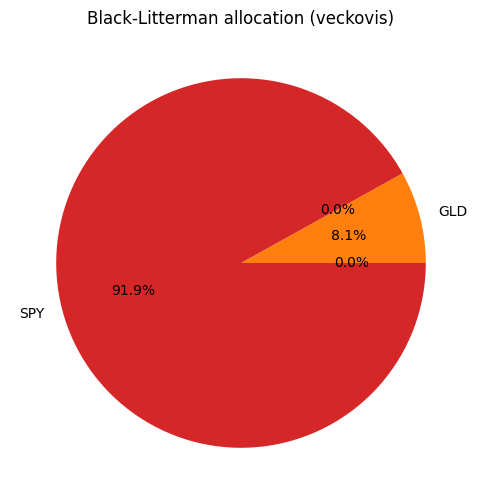

In [3]:

# ▸ 2. WEEKLY views + confidences  ------------------------------------
# Views: använder conditional mean dvs kollar genomsnittlig avkastning vid denna fgi-kategori-värde
def weekly_views(sent_df, price_df):
    sent_w = sent_df.assign(Date=pd.to_datetime(sent_df["Date"]))\
                    .set_index("Date")\
                    .resample("W-FRI").last().dropna()
    px_w   = price_df.resample("W-FRI").last()

    colmap = {"SPY_FGI":"SPY", "BND_FGI":"BND",
              "GLD_FGI":"GLD", "Crypto_FGI":"HODL.PA"}
    views, conf = {}, []
    for scol, tic in colmap.items():
        fgi  = sent_w[scol] # ex SPY_FGI
        prc  = px_w[tic].loc[fgi.index] # ex SPY-pris, samma datum
        fwd  = np.log(prc.shift(-1)/prc)          # 1-veckas log-retur, förflyttar prisserien en vecka fram (shift −1) och jämför med dagens pris.
        tmp  = pd.concat({"cls":fgi,"fwd":fwd}, axis=1).dropna()
        cls  = int(fgi.iloc[-1])                  # sista (senaste) observe­rade värdet 0-4
        views[tic] = tmp.groupby("cls")["fwd"].mean().get(cls, 0.0) #views
        conf.append(1 / (tmp.query("cls==@cls")["fwd"].var() + 1e-8))
    conf = (np.array(conf)/np.max(conf)).tolist()
    return views, conf

# sentiment-baserade vyer (SPY, BND, GLD)
viewdict_sent, conf_sent = weekly_views(merged.copy(), closing_prices)

# ersätt HODL-raden med ML-värden
viewdict_sent["HODL.PA"] = mu_hodl
# conf_sent ligger i samma ordning som ["SPY","BND","GLD","HODL.PA"]
conf_sent[-1] = conf_hodl                    # sista elementet är för HODL

viewdict    = viewdict_sent
confidences = conf_sent
confidences = (np.array(confidences) / np.max(confidences)).tolist() #normalisera 0-1
print("Views:", viewdict)
print("Conf :", confidences)

# ▸ 3. BLACK-LITTERMAN  ------------------------------------------------
mcaps = {
    "SPY": 481_714_784_600,
    "BND": 122_936_437_056,
    "GLD":  77_500_318_000,
    "HODL.PA": 1_200_295_500,
}
cov   = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(closing_prices["SPY"])
pi    = black_litterman.market_implied_prior_returns(mcaps, delta, cov)

bl = BlackLittermanModel(
    cov,
    pi=pi,
    absolute_views=viewdict,
    omega="idzorek",
    view_confidences=confidences,
    risk_aversion=delta,
)
ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
ef.max_sharpe()
weights = ef.clean_weights()

print("\nOPTIMERAD PORTFÖLJ (weekly BL):")
for k, v in weights.items():
    print(f"  {k:7s}: {v*100:5.1f} %")

# (valfritt) visa fördelningen
pd.Series(weights).plot.pie(figsize=(6,6), autopct='%1.1f%%')
plt.ylabel("")
plt.title("Black-Litterman allocation (veckovis)")
plt.show()
